# Optimize controls
**Highly-configurable non-linear optimization framework for quantum control**

The Q-CTRL Python package exposes a highly-flexible optimization engine for general-purpose gradient-based optimization.

The optimization engine provides a large, modular collection of configuration options in order to support a wide variety of systems and constraints relevant to quantum control. These options can be combined in different ways to produce optimization solutions tailored to specific systems. In this guide we demonstrate optimization using several different types of systems and constraints, to give a taste of the available flexibility. All the techniques presented here can be cross-combined to yield an even wider class of supported configurations.

## Imports and initialization

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from qctrlvisualizer import get_qctrl_style, plot_controls

from qctrl import Qctrl

plt.style.use(get_qctrl_style())

# Sparse matrix imports
from scipy.sparse import coo_matrix

# Starting a session with the API
qctrl = Qctrl()

## Functions

In [4]:
def get_infidelity(qctrl, H_func, target_U, names=["alpha", "gamma"]):

    # Define the data flow graph describing the system
    with qctrl.create_graph() as graph:

        hamiltonian, noise = H_func(qctrl)

        # Create the target operator
        target_operator = qctrl.operations.target(operator=target_U)

        # Create infidelity
        infidelity = qctrl.operations.infidelity_pwc(
            hamiltonian=qctrl.operations.pwc_sum(hamiltonian),
            noise_operators=noise,
            target_operator=target_operator,
            name="infidelity",
        )
        
    optimization_result = qctrl.functions.calculate_optimization(
        cost_node_name="infidelity",
        output_node_names=names,
        graph=graph,
    )
        
    return optimization_result

def plot_results(optimization_result, names=["alpha", "gamma"], labels=None):
    
    if labels is None:
        labels = names
        
    controls = {}
    for label, name in zip(labels, names):
        controls["$\\"+label+"$"] = optimization_result.output[name]
        
    plot_controls(
        plt.figure(),
        controls=controls,
    )
    plt.show()


def get_results(qctrl, H_func, target_U, names=["alpha", "gamma"], labels=None):
    optimization_result = get_infidelity(qctrl, H_func, target_U, names=names)
    print("Optimized cost:\t", optimization_result.cost)
    plot_results(optimization_result, names=names, labels=labels)

## Worked example: Robust control of a single qubit

We first present a detailed worked example of robust optimization in a single-qubit system. Specifically, we consider a single-qubit system represented by the following Hamiltonian:

\begin{align*}
H(t) &= \frac{\nu}{2} \sigma_{z} + \frac{1}{2}\left(\gamma(t)\sigma_{-} + \gamma^*(t)\sigma_{+}\right) + \frac{\alpha(t)}{2} \sigma_{z} + \beta(t) \sigma_{z} \,, 
\end{align*}

where $\nu$ is the qubit detuning, $\gamma(t)$ and $\alpha(t)$ are, respectively, complex and real time-dependent pulses, and $\beta(t)$ is a small, slowly-varying stochastic dephasing noise process and $\sigma_{\pm}$ are the qubit ladder operators and $\sigma_{z}$ is the Pauli-Z operator.

The functions of time $\gamma(t)$ and $\alpha(t)$ are not predetermined, and instead are optimized by the Q-CTRL optimization engine in order to achieve some target operation.

### Defining the graph

The flexible Q-CTRL optimization engine expresses all optimization problems as data flow graphs, which describe how optimization variables (variables that can be tuned by the optimizer) are transformed into the cost function (the objective that the optimizer attempts to minimize).

Below we show how to create a data flow graph for optimizing the single-qubit system described above. Comments in the code explain the details of each step.

In [18]:
# Define standard matrices
sigma_x = np.array([[0, 1], [1, 0]])
sigma_y = np.array([[0, -1j], [1j, 0]])
sigma_z = np.array([[1, 0], [0, -1]])
sigma_m = np.array([[0, 1], [0, 0]])
hadamard = np.array([[1, 1], [1, -1]]) / np.sqrt(2)

hadamard_leak = np.array(
    [[1.0, 1.0, 0], [1.0, -1.0, 0], [0, 0, np.sqrt(2)]], dtype=np.complex
) / np.sqrt(2)
sigma_x_leak = np.array(
    [[0, 1.0, 0], [1.0, 0, 0], [0, 0, 1.]], dtype=np.complex)

<ipython-input-18-a3049900e6e6>:9: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  [[1.0, 1.0, 0], [1.0, -1.0, 0], [0, 0, np.sqrt(2)]], dtype=np.complex
<ipython-input-18-a3049900e6e6>:12: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  [[0, 1.0, 0], [1.0, 0, 0], [0, 0, 1.]], dtype=np.complex)


In [6]:
def H1(qctrl):
    # Define physical constants
    nu = 2 * np.pi * 0.5 * 1e6  # Hz
    gamma_max = 2 * np.pi * 0.5e6  # Hz
    alpha_max = 2 * np.pi * 0.5e6  # Hz
    segment_count = 50
    duration = 10e-6  # s
    
    # Create a constant piecewise-constant (PWC) operator representing the
    # detuning term
    detuning = qctrl.operations.constant_pwc_operator(
        duration=duration,
        operator=nu * sigma_z / 2,
    )

    # Create a complex PWC signal, with optimizable modulus and phase,
    # representing gamma(t)
    gamma = qctrl.operations.complex_pwc_signal(
        moduli=qctrl.operations.bounded_optimization_variable(
            count=segment_count,
            lower_bound=0,
            upper_bound=gamma_max,
        ),
        phases=qctrl.operations.unbounded_optimization_variable(
            count=segment_count,
            initial_lower_bound=0,
            initial_upper_bound=2 * np.pi,
        ),
        duration=duration,
        name="gamma",
    )
    # Create a PWC operator representing the drive term
    drive = qctrl.operations.pwc_operator_hermitian_part(
        qctrl.operations.pwc_operator(signal=gamma, operator=sigma_m)
    )

    # Create a real PWC signal, with optimizable amplitude, representing
    # alpha(t)
    alpha = qctrl.operations.pwc_signal(
        values=qctrl.operations.bounded_optimization_variable(
            count=segment_count, lower_bound=-alpha_max, upper_bound=alpha_max
        ),
        duration=duration,
        name="alpha",
    )
    # Create a PWC operator representing the clock shift term
    shift = qctrl.operations.pwc_operator(signal=alpha, operator=sigma_z / 2)

    # Create a constant PWC operator representing the dephasing noise
    # (note that we scale by 1/duration to ensure consistent units between
    # the noise Hamiltonian and the control Hamiltonian)
    dephasing = qctrl.operations.constant_pwc_operator(
        duration=duration, operator=sigma_z / duration
    )
    
    hamiltonian = [detuning, drive, shift]
    
    noise = [dephasing]
    
    return hamiltonian, noise

  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_optimization has started.
Your task calculate_optimization has completed in 6s.
Optimized cost:	 5.10196026461212e-13


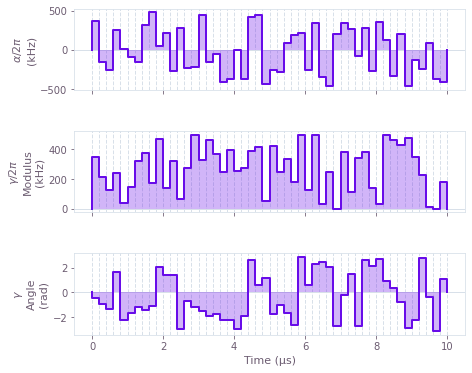

In [7]:
get_results(qctrl, H1, sigma_x)

## Example: Time-symmetrized pulses

Next we show how time symmetry can be incorporated into the optimization problem. In some cases, forcing control pulses to exhibit time symmetry can yield natural noise robustness while simplifying the optimization problem (by halving the dimensionality of the search space). In this example, we perform a robust optimization of a single qubit using symmetric pulses. The single-qubit system is represented by the following Hamiltonian:

\begin{align*}
H(t) &= \frac{\nu}{2} \sigma_{z} + \frac{1}{2}\left(\gamma(t)\sigma_{-} + \gamma^*(t)\sigma_{+}\right) + \frac{\alpha(t)}{2} \sigma_{z} + \beta(t) \sigma_{z} \,, 
\end{align*}

where $\nu$ is the qubit detuning, $\gamma(t)$ and $\alpha(t)$ are, respectively, complex and real time-dependent pulses, and $\beta(t)$ is a small, slowly-varying stochastic dephasing noise process.

To enforce time symmetry, we create the control signals in two steps: we first create a standard signal for the first half of the gate duration, and then we create a copy (depending on the same underlying control parameters) that gets reflected and concatenated with the original signal.

In [8]:
def H2(qctrl):

    # Define physical constraints
    gamma_max = 2 * np.pi * 8.5e6  # Hz
    alpha_max = 2 * np.pi * 8.5e6  # Hz
    nu = 2 * np.pi * 6e6  # Hz
    segment_count = 50
    duration = 154e-9  # s
    
    # Create detuning term
    detuning = qctrl.operations.constant_pwc_operator(
        duration=duration,
        operator=nu * sigma_z / 2,
    )

    # Create a complex PWC signal describing the first half of gamma(t)
    half_gamma = qctrl.operations.complex_pwc_signal(
        moduli=qctrl.operations.bounded_optimization_variable(
            count=segment_count, lower_bound=0, upper_bound=gamma_max
        ),
        phases=qctrl.operations.unbounded_optimization_variable(
            count=segment_count,
            initial_lower_bound=0,
            initial_upper_bound=2 * np.pi,
        ),
        duration=duration / 2,
    )
    # Define gamma(t) by symmetrizing half_gamma
    gamma = qctrl.operations.symmetrize_pwc(
        half_gamma,
        name="gamma",
    )
    # Create drive term
    drive = qctrl.operations.pwc_operator_hermitian_part(
        qctrl.operations.pwc_operator(signal=gamma, operator=sigma_m)
    )

    # Create alpha(t) similarly
    alpha = qctrl.operations.symmetrize_pwc(
        qctrl.operations.pwc_signal(
            values=qctrl.operations.bounded_optimization_variable(
                count=segment_count, lower_bound=-alpha_max, upper_bound=alpha_max
            ),
            duration=duration / 2,
        ),
        name="alpha",
    )
    # Create clock shift term
    shift = qctrl.operations.pwc_operator(signal=alpha, operator=sigma_z / 2)

    # Create dephasing noise term
    dephasing = qctrl.operations.constant_pwc_operator(
        duration=duration, operator=sigma_z / duration
    )
    
    hamiltonian = [detuning, drive, shift]
    
    noise = [dephasing]
    
    return hamiltonian, noise

  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_optimization has started.
Your task calculate_optimization has completed in 6s.
Optimized cost:	 1.5842485011957516e-10


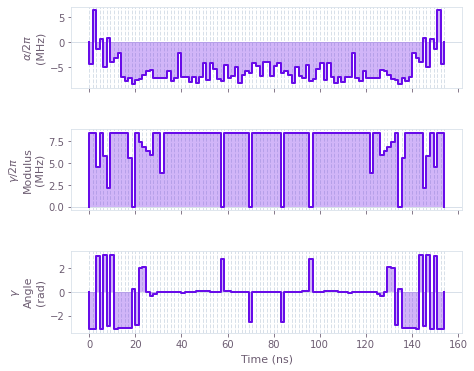

In [9]:
get_results(qctrl, H2, sigma_x)

## Example: Non-linear dependence on control pulses

We next present an example showing how a system with non-linear dependence between controls and Hamiltonian may be optimized. We consider an artificial single-qubit system represented by the following Hamiltonian:

\begin{align*}
H(t) &= \alpha_1(t)\sigma_x + \frac{\alpha_1(t)^2}{\alpha_{\text{max}}}\sigma_y + \alpha_2(t)\sigma_z \,,  
\end{align*}

where $\alpha_1(t)$ and $\alpha_2(t)$ are real time-dependent pulses, and we note the non-linear dependence of the Hamiltonian on $\alpha_1(t)$. While here we have chosen a simple artificial non-linearity for the sake of convenience and brevity, the approach we demonstrate extends trivially to far more complex, physically-relevant situations.

Expressing non-linear dependence between control parameters and Hamiltonians is achieved by performing standard arithmetical operations on the control parameters prior to constructing signals. In this case the operations are very simple&mdash;we simply square and re-scale the parameters describing the $\alpha_1(t)$ values&mdash;but in general any combination of supported primitive operations may be used.

In [10]:
def H3(qctrl):

    # Define physical constraints
    alpha_max = 2 * np.pi * 6e6  # Hz
    segment_count = 40
    duration = 200e-9  # s

    # Create the values backing the alpha_1(t) signal
    alpha_1_values = qctrl.operations.bounded_optimization_variable(
        count=segment_count,
        lower_bound=-alpha_max,
        upper_bound=alpha_max,
    )

    # Create the alpha_1(t) signal
    alpha_1 = qctrl.operations.pwc_signal(
        values=alpha_1_values, duration=duration, name="alpha_1"
    )

    # Apply a non-linear transformation to create the alpha_1_squared(t) signal
    alpha_1_squared_values = alpha_1_values * (alpha_1_values / alpha_max)
    alpha_1_squared = qctrl.operations.pwc_signal(
        values=alpha_1_squared_values, duration=duration, name="alpha_1_squared"
    )

    # Create the alpha_2(t) signal
    alpha_2 = qctrl.operations.pwc_signal(
        values=qctrl.operations.bounded_optimization_variable(
            count=segment_count, lower_bound=-alpha_max, upper_bound=alpha_max
        ),
        duration=duration,
        name="alpha_2",
    )

    # Create Hamiltonian terms
    x_term = qctrl.operations.pwc_operator(signal=alpha_1, operator=sigma_x)
    y_term = qctrl.operations.pwc_operator(signal=alpha_1_squared, operator=sigma_y)
    z_term = qctrl.operations.pwc_operator(signal=alpha_2, operator=sigma_z)
    
    hamiltonian = [x_term, y_term, z_term]
    
    noise = None
    
    return hamiltonian, noise

  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_optimization has started.
Your task calculate_optimization has completed in 6s.
Optimized cost:	 3.552713678800501e-15


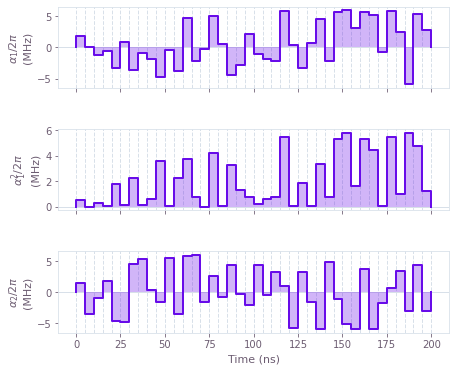

In [11]:
get_results(qctrl, H3, sigma_x, names=["alpha_1", "alpha_1_squared", "alpha_2"], labels=["alpha_1", "alpha_1^2", "alpha_2"])

## Example: Band-limited pulses with bounded slew rates

Next we show how to optimize a system in which the rates of change of the controls are limited. Using this constraint can help to ensure that optimized controls can be reliably implemented on physical hardware (which may be subject to bandwidth limits). We consider a standard single-qubit system subject to dephasing noise:

\begin{align*}
H(t) &= \frac{1}{2} \alpha_1(t)\sigma_{x} + \frac{1}{2} \alpha_2(t) \sigma_{z} + \beta(t) \sigma_{z} \,, 
\end{align*}

where $\alpha_1(t)$ and $\alpha_2(t)$ are real time-dependent pulse and $\beta(t)$ is a small, slowly-varying stochastic dephasing noise process. In this case, we enforce a maximum slew rate constraint on $\alpha_1(t)$ and $\alpha_2(t)$, to cap the variation between adjacent segment values.

To implement a bounded slew rate, we create signal values using a Q-CTRL helper function,
[`qctrl.operations.anchored_difference_bounded_variables`](https://docs.q-ctrl.com/boulder-opal/references/qctrl/Operations/anchored_difference_bounded_variables.html). This function produces values that are constrained to satisfy the slew rate requirement, and in addition are anchored to zero at the start and end of the gate.

In [14]:
def H4(qctrl):

    # Define physical constraints
    alpha_max = 2 * np.pi * 8.5e6  # Hz
    max_slew_rate = alpha_max / 10
    segment_count = 250
    duration = 400e-9  # s

    # Create alpha_1(t) signal
    alpha_1_values = qctrl.operations.anchored_difference_bounded_variables(
        count=segment_count,
        lower_bound=-alpha_max,
        upper_bound=alpha_max,
        difference_bound=max_slew_rate,
    )
    alpha_1 = qctrl.operations.pwc_signal(
        values=alpha_1_values, duration=duration, name="alpha_1"
    )

    # Create alpha_2(t) signal
    alpha_2_values = qctrl.operations.anchored_difference_bounded_variables(
        count=segment_count,
        lower_bound=-alpha_max,
        upper_bound=alpha_max,
        difference_bound=max_slew_rate,
    )
    alpha_2 = qctrl.operations.pwc_signal(
        values=alpha_2_values, duration=duration, name="alpha_2"
    )

    # Create drive term
    drive = qctrl.operations.pwc_operator_hermitian_part(
        qctrl.operations.pwc_operator(signal=alpha_1, operator=sigma_x / 2)
    )

    # Create clock shift term
    shift = qctrl.operations.pwc_operator(signal=alpha_2, operator=sigma_z / 2)

    # Create dephasing noise term
    dephasing = qctrl.operations.constant_pwc_operator(
        duration=duration, operator=sigma_z / duration
    )
    
    hamiltonian = [drive, shift]
    
    noise = [dephasing]
    
    return hamiltonian, noise

  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_optimization has started.
Your task calculate_optimization has completed in 30s.
Optimized cost:	 9.558096688745738e-12


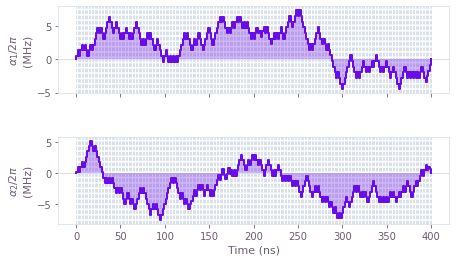

In [15]:
get_results(qctrl, H4, sigma_x, names = ["alpha_1", "alpha_2"])

## Example: Band-limited pulses with filters

Next we show how to optimize a system using a different technique for enforcing pulse band limits, namely filtering. As above, producing band-limited controls can help to ensure that optimized controls can be reliably implemented on physical hardware, but in some cases one desires tighter control over the frequency domain behavior of the controls than what can be achieved with a slew rate bound. The technique we use here is to pass the controls through a linear time-invariant filter in order to enforce explicit bandwidth limits. We consider, once again, a standard single-qubit system subject to dephasing noise:

\begin{align*}
H(t) &= \frac{1}{2} \alpha_1(t)\sigma_{x} + \frac{1}{2} \alpha_2(t) \sigma_{z} + \beta(t) \sigma_{z} \,, 
\end{align*}

where $\alpha_1(t)$ and $\alpha_2(t)$ are real time-dependent pulse and $\beta(t)$ is a small, slowly-varying stochastic dephasing noise process. In this case we force $\alpha_1(t)$ and $\alpha_2(t)$ to be signals produced from an ideal sinc filter, which forces the signals to exhibit a hard upper bound in the frequency domain.

To implement this behavior, we create optimizable signals as usual, and then use the [`qctrl.operations.convolve_pwc`](https://docs.q-ctrl.com/boulder-opal/references/qctrl/Operations/convolve_pwc.html) (to apply a filter) and [`qctrl.operations.discretize_stf`](https://docs.q-ctrl.com/boulder-opal/references/qctrl/Operations/discretize_stf.html) (to obtain a piecewise-constant discretization of the smooth filtered signal) functions to derive band-limited signals. These band-limited signals are then used to construct the Hamiltonian.

In [16]:
def H5(qctrl):

    # Define physical constraints
    alpha_max = 2 * np.pi * 8.5e6  # Hz
    sinc_cutoff_frequency = 2 * np.pi * 48e6  # Hz
    nu = 2 * np.pi * 6e6  # Hz
    segment_count = 50
    duration = 400e-9  # s
    
    # Create initial alpha_1(t) signal
    alpha_1_values = qctrl.operations.bounded_optimization_variable(
        count=segment_count,
        lower_bound=-alpha_max,
        upper_bound=alpha_max,
    )
    alpha_1 = qctrl.operations.pwc_signal(
        values=alpha_1_values,
        duration=duration,
    )
    # Create filtered signal
    alpha_1_filtered = qctrl.operations.convolve_pwc(
        alpha_1,
        qctrl.operations.sinc_integral_function(sinc_cutoff_frequency),
    )
    # Discretize to obtain smoothed alpha_1(t) signal
    alpha_1 = qctrl.operations.discretize_stf(
        stf=alpha_1_filtered,
        duration=duration,
        segments_count=segment_count,
        name="alpha_1",
    )

    # Similarly, create alpha_2(t) signal
    alpha_2_values = qctrl.operations.bounded_optimization_variable(
        count=segment_count,
        lower_bound=-alpha_max,
        upper_bound=alpha_max,
    )
    alpha_2 = qctrl.operations.pwc_signal(
        values=alpha_2_values,
        duration=duration,
    )
    # Create filtered signal
    alpha_2_filtered = qctrl.operations.convolve_pwc(
        alpha_2,
        qctrl.operations.sinc_integral_function(sinc_cutoff_frequency),
    )
    # Discretize to obtain smoothed alpha_2(t) signal
    alpha_2 = qctrl.operations.discretize_stf(
        stf=alpha_2_filtered,
        duration=duration,
        segments_count=segment_count,
        name="alpha_2",
    )

    # Create drive term
    drive = qctrl.operations.pwc_operator_hermitian_part(
        qctrl.operations.pwc_operator(signal=alpha_1, operator=sigma_x / 2)
    )

    # Create clock shift term
    shift = qctrl.operations.pwc_operator(signal=alpha_2, operator=sigma_z / 2)

    # Create dephasing noise term
    dephasing = qctrl.operations.constant_pwc_operator(
        duration=duration, operator=sigma_z / duration
    )
    
    hamiltonian = [drive, shift]
    
    noise = [dephasing]
    
    return hamiltonian, noise

  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_optimization has started.
Your task calculate_optimization has completed in 6s.
Optimized cost:	 1.2727945395894726e-12


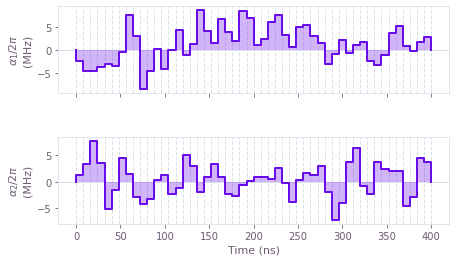

In [17]:
get_results(qctrl, H5, sigma_x, names = ["alpha_1", "alpha_2"])

## Example: Incorporating smoothing via linear filters on control signals

We next present an example showing how systems containing linear time-invariant filters can be optimized. Unlike the example above, where we employed such filters in order to produce smooth controls, here we consider the case where such filters are present in the system itself. In this particular example, we consider the common scenario in which electronic filters are present on the control lines. Specifically, we consider a basic single-qubit system:

\begin{align*}
H(t) &= \frac{1}{2} L(\alpha_1)(t)\sigma_{x} + \frac{1}{2} L(\alpha_2)(t) \sigma_{z} + \beta(t) \sigma_{z}  \,, 
\end{align*}

where $\alpha_1(t)$ and $\alpha_2(t)$ are real time-dependent pulses, $\beta(t)$ is a small, slowly-varying stochastic dephasing noise process, and $ L$ is a sinc filter applied to the pulses. The effect of these filters is to transform the control signals before they reach the quantum system, via convolution with the filter impulse response. Failing to take the filters into account during the optimization can lead to poor results, since in that case the system used for the optimization does not accurately model reality.

As above, we use the [`qctrl.operations.convolve_pwc`](https://docs.q-ctrl.com/boulder-opal/references/qctrl/Operations/convolve_pwc.html) function to apply a filter (obtained via the [`qctrl.operations.sinc_integral_function`](https://docs.q-ctrl.com/boulder-opal/references/qctrl/Operations/sinc_integral_function.html) function) to a piecewise-constant signal. The resulting smooth tensor function (STF) may then be manipulated in exactly the same way as piecewise-constant functions, up to and including calculating the infidelity. We stress that even though highly irregular pulses are generated for $\alpha_1(t)$ and $\alpha_2(t)$, these pulses are chosen so that, *when smoothed by the filters in the system*, they will effect a high-quality gate. 

In [25]:
def H6(qctrl):
    
    # Define physical constraints
    alpha_max = 2 * np.pi * 8.5e6  # Hz
    nu = 2 * np.pi * 6e6  # Hz
    sinc_cutoff_frequency = 2 * np.pi * 48e6  # Hz
    segment_count = 50
    duration = 250e-9  # s
    
    # Create alpha_1(t) signal
    alpha_1_values = qctrl.operations.bounded_optimization_variable(
        count=segment_count,
        lower_bound=-alpha_max,
        upper_bound=alpha_max,
    )
    alpha_1 = qctrl.operations.pwc_signal(
        values=alpha_1_values,
        duration=duration,
        name="alpha_1",
    )
    # Create filtered signal
    alpha_1_filtered = qctrl.operations.convolve_pwc(
        alpha_1,
        qctrl.operations.sinc_integral_function(sinc_cutoff_frequency),
    )

    # Similarly, create filtered alpha_2(t) signal
    alpha_2_values = qctrl.operations.bounded_optimization_variable(
        count=segment_count,
        lower_bound=-alpha_max,
        upper_bound=alpha_max,
    )
    alpha_2 = qctrl.operations.pwc_signal(
        values=alpha_2_values,
        duration=duration,
        name="alpha_2",
    )
    alpha_2_filtered = qctrl.operations.convolve_pwc(
        alpha_2,
        qctrl.operations.sinc_integral_function(sinc_cutoff_frequency),
    )

    # Create drive term (note the use of STF functions instead of PWC functions,
    # because we are dealing with smooth signals instead of piecewise-constant
    # signals).
    drive = qctrl.operations.stf_operator(alpha_1_filtered, sigma_x / 2)
    # Create clock shift term
    shift = qctrl.operations.stf_operator(alpha_2_filtered, sigma_z / 2)

    # Create dephasing noise term
    dephasing = qctrl.operations.constant_stf_operator(sigma_z / duration)
    
    # Sample filtered signals (to output and plot)
    alpha_1_smooth = qctrl.operations.discretize_stf(
        stf=alpha_1_filtered,
        duration=duration,
        segments_count=500,
        name="alpha_1_filtered",
    )
    alpha_2_smooth = qctrl.operations.discretize_stf(
        stf=alpha_2_filtered,
        duration=duration,
        segments_count=500,
        name="alpha_2_filtered",
    )
    
    hamiltonian = [drive, shift]
    
    noise = [dephasing]
    
    return hamiltonian, noise, duration

  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_optimization has started.
Your task calculate_optimization has completed in 6s.
Optimized cost:	 5.004286037141941e-11


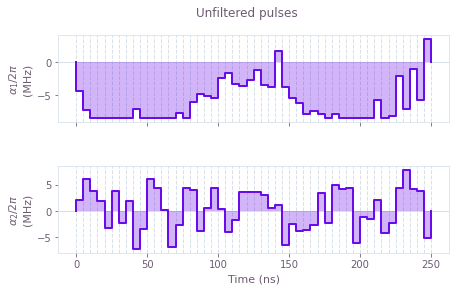

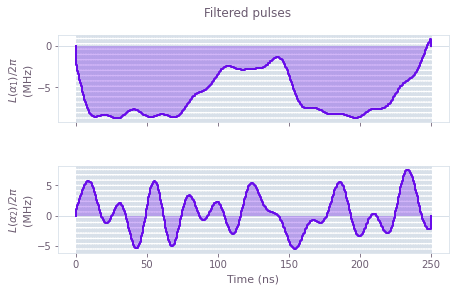

In [26]:
# Create graph object
with qctrl.create_graph() as graph:
    
    hamiltonian, noise, duration = H6(qctrl)
    
    # Create target
    target_operator = qctrl.operations.target(operator=sigma_x)

    # Create infidelity (note that we pass an array of sample times, which
    # governs the granularity of the integration procedure)
    infidelity = qctrl.operations.infidelity_stf(
        np.linspace(0, duration, 150),
        qctrl.operations.stf_sum(hamiltonian),
        target_operator,
        noise,
        name="infidelity",
    )

# Run the optimization
optimization_result = qctrl.functions.calculate_optimization(
    cost_node_name="infidelity",
    output_node_names=["alpha_1", "alpha_2", "alpha_1_filtered", "alpha_2_filtered"],
    graph=graph,
)

print("Optimized cost:\t", optimization_result.cost)

# Plot the optimized controls
plot_controls(
    plt.figure(),
    controls={
        "$\\alpha_1$": optimization_result.output["alpha_1"],
        "$\\alpha_2$": optimization_result.output["alpha_2"],
    },
)
plt.suptitle("Unfiltered pulses")

plot_controls(
    plt.figure(),
    controls={
        "$L(\\alpha_1)$": optimization_result.output["alpha_1_filtered"],
        "$L(\\alpha_2)$": optimization_result.output["alpha_2_filtered"],
    },
)
plt.suptitle("Filtered pulses")

plt.show()

## Example: CRAB optimization

In **c**hopped **ra**ndom **b**asis (CRAB) optimization, pulses are defined via optimizable linear combinations from a set of basis functions, which can greatly reduce the dimensionality of the optimization search space. Traditionally, a [randomized Fourier basis](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.106.190501) is used, although the same technique has also seen success with other bases, for example [Slepian functions](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.97.062346). In this example, we perform a CRAB optimization (in the Fourier basis) of a qutrit system in which we effect a single-qubit gate while minimizing leakage out of the computational subspace. The system is described by the following Hamiltonian:

\begin{align*}
H(t) = & \frac{\chi}{2} (a^\dagger)^2 a^2 + \gamma(t) (1+\beta(t))a + \gamma^*(t)(1+\beta(t)) a^\dagger + \frac{\alpha(t)}{2} a^\dagger a \,, 
\end{align*}

where $\chi$ is the anharmonicity, $\gamma(t)$ and $\alpha(t)$ are, respectively, complex and real time-dependent pulses, $\beta$ is a small, slowly-varying stochastic amplitude noise process, and $a = |0 \rangle \langle 1 | + \sqrt{2} |1 \rangle \langle 2 |$.

The Q-CTRL optimization engine provides a convenience function, [`qctrl.operations.real_fourier_pwc_signal`](https://docs.q-ctrl.com/boulder-opal/references/qctrl/Operations/real_fourier_pwc_signal.html), for creating optimizable signals in a Fourier basis, suitable for use in a CRAB optimization. Other bases are supported by the framework, but require the user to manually provide operations that compute the appropriate linear combinations.

In [27]:
def H7(qctrl):
    # Define standard matrices
    a = np.array(
        [[0.0, 1.0, 0.0], [0.0, 0.0, np.sqrt(2)], [0.0, 0.0, 0.0]], dtype=np.complex
    )
    ada = np.matmul(a.T, a)
    ad2a2 = np.matmul(np.matmul(a.T, a.T), np.matmul(a, a))
    qubit_projector = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 0]], dtype=np.complex)

    # Define physical constraints
    chi = 2 * np.pi * -300.0 * 1e6  # Hz
    gamma_max = 2 * np.pi * 30e6  # Hz
    alpha_max = 2 * np.pi * 30e6  # Hz
    segment_count = 200
    duration = 100e-9  # s

    # Create gamma(t) signal in Fourier bases. To demonstrate the full
    # flexibility, we show how to use both randomized and optimizable
    # basis elements. Elements with fixed frequencies may be chosen too.
    gamma_i = qctrl.operations.real_fourier_pwc_signal(
        duration=duration,
        segments_count=segment_count,
        randomized_frequencies_count=10,
    )
    gamma_q = qctrl.operations.real_fourier_pwc_signal(
        duration=duration,
        segments_count=segment_count,
        optimizable_frequencies_count=10,
    )
    gamma = qctrl.operations.pwc_signal(
        duration=duration,
        values=qctrl.operations.complex_value(real=gamma_i.values, imag=gamma_q.values)
        * gamma_max,
        name="gamma",
    )

    # Create alpha(t) signal
    alpha = qctrl.operations.real_fourier_pwc_signal(
        duration=duration,
        segments_count=segment_count,
        initial_coefficient_lower_bound=-alpha_max,
        initial_coefficient_upper_bound=alpha_max,
        optimizable_frequencies_count=10,
        name="alpha",
    )

    # Create anharmonicity term
    anharmonicity = qctrl.operations.constant_pwc_operator(
        duration,
        ad2a2 * chi / 2,
    )
    # Create drive term
    drive = qctrl.operations.pwc_operator_hermitian_part(
        qctrl.operations.pwc_operator(signal=gamma, operator=2 * a)
    )

    # Create clock shift term
    shift = qctrl.operations.pwc_operator(signal=alpha, operator=ada / 2)
    
    hamiltonian = [anharmonicity, drive, shift]
    
    noise = [drive]
    
    return hamiltonian, noise

<ipython-input-27-d30a0a138350>:2: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  [[1.0, 1.0, 0], [1.0, -1.0, 0], [0, 0, np.sqrt(2)]], dtype=np.complex
<ipython-input-27-d30a0a138350>:5: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  [[0, 1.0, 0], [1.0, 0, 0], [0, 0, np.sqrt(2)]], dtype=np.complex)


In [28]:
# Run the optimization
optimization_result = get_infidelity(qctrl, H7, sigma_x_leak)

print("Optimized cost:\t", optimization_result.cost)

plot_results(optimization_result)

<ipython-input-27-d30a0a138350>:10: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  [[0.0, 1.0, 0.0], [0.0, 0.0, np.sqrt(2)], [0.0, 0.0, 0.0]], dtype=np.complex
<ipython-input-27-d30a0a138350>:14: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  qubit_projector = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 0]], dtype=np.complex)


QctrlArgumentsValueError: operator must be a partial isometry, but does not yield itself when multiplied by its adjoint and then itself.
operator=array([[0.        +0.j, 1.        +0.j, 0.        +0.j],
       [1.        +0.j, 0.        +0.j, 0.        +0.j],
       [0.        +0.j, 0.        +0.j, 1.41421356+0.j]])

## Example: Optimizing large systems with sparse Hamiltonians

You can carry out the optimization of larger systems by using approximate integration methods that are more computationally effective. This is especially helpful when the Hamiltonian is sparse. To illustrate this, consider a system of four qubits where each qubit only interacts with the nearest neighbor through an XX coupling operator:

$$ H = \frac{1}{2} \sum_{i=1}^3 \Omega_i(t) \sigma_{x,i} \sigma_{x,i+1}. $$

Suppose you start from the state $\left| 0000 \right\rangle$ and want to create the state $\left(\left| 0000 \right\rangle +i\left| 0011 \right\rangle -i\left| 1100 \right\rangle+ \left| 1111 \right\rangle \right)/2$ by using optimized controls for $\Omega_1(t)$, $\Omega_2(t)$, and $\Omega_3(t)$. To do this, you can define the Hamiltonian terms as sparse matrices (as the [`coo_matrix`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.coo_matrix.html) object from the `scipy` package) and integrate them using the [Lanczos algorithm](https://en.wikipedia.org/wiki/Lanczos_algorithm) that is available in the function [`qctrl.operations.state_evolution_pwc`](https://docs.q-ctrl.com/boulder-opal/references/qctrl/Operations/state_evolution_pwc.html).

The Lanczos algorithm accepts a parameter called the `krylov_subspace_dimension`, which controls the accuracy of the operation. You can choose this parameter manually or use the operation [`qctrl.operations.estimated_krylov_subspace_dimension`](https://docs.q-ctrl.com/boulder-opal/references/qctrl/Operations/estimated_krylov_subspace_dimension.html) to obtain an estimate of its best choice for your Hamiltonian and error tolerance. The following code shows how to obtain this estimate for an integration accuracy of `1e-5` and then how to optimize the controls using it. The code also prints a comparison between the integration that uses the Lanczos algorithm and the exact integration. The difference between the exact result and the Lanczos integration is well within the `1e-5` accuracy.

  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_graph has completed in 3s.


  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_optimization has started.
Your task calculate_optimization has completed in 14s.
Recommended Krylov subspace dimension:	10
Final state infidelity:			2.042810365310288e-14 (Lanczos integration)
Final state infidelity:			8.43769498715119e-14 (Exact integration)


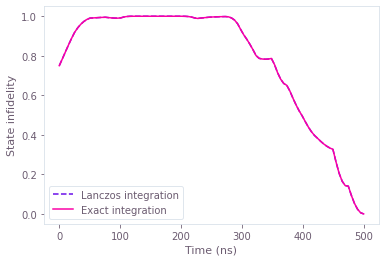

In [12]:
# Define standard matrices
sigma_x = np.array([[0, 1], [1, 0]], dtype=np.complex128)

# Define physical constraints
omega_max = 2 * np.pi * 5e6  # Hz
duration = 500e-9  # s
segment_count = 20
sample_times = np.linspace(0, duration, 100)
initial_state = np.array([1] + [0] * 15)
target_state = np.zeros(2 ** 4, complex)
target_state[int("0000", 2)] = 1 / 2
target_state[int("0011", 2)] = 1j / 2
target_state[int("1100", 2)] = -1j / 2
target_state[int("1111", 2)] = 1 / 2

# Define coupling operators as sparse matrices
operators = [
    coo_matrix(0.5 * np.kron(np.kron(sigma_x, sigma_x), np.eye(4)), shape=(16, 16)),
    coo_matrix(
        0.5 * np.kron(np.kron(np.eye(2), np.kron(sigma_x, sigma_x)), np.eye(2)),
        shape=(16, 16),
    ),
    coo_matrix(0.5 * np.kron(np.eye(4), np.kron(sigma_x, sigma_x)), shape=(16, 16)),
]

# Build Krylov subspace dimension estimation graph
with qctrl.create_graph() as graph:

    # Find the spectral range for the Hamiltonian with highest omega value
    spectral_range = qctrl.operations.spectral_range(
        operator=omega_max * sum(operators).tocoo(),
    )

    # Find the suggested Krylov subspace dimension for that spectral range
    # and error tolerance of 1e-5
    qctrl.operations.estimated_krylov_subspace_dimension(
        spectral_range=spectral_range,
        duration=duration,
        maximum_segment_duration=duration / segment_count,
        error_tolerance=1e-5,
        name="krylov_subspace_dimension",
    )

# Run the calculation for the recommended Krylov subspace dimension
krylov_subspace_dimension = qctrl.functions.calculate_graph(
    graph=graph,
    output_node_names=["krylov_subspace_dimension"],
).output["krylov_subspace_dimension"]["value"]

# Build optimization graph
with qctrl.create_graph() as graph:

    # Define individual control signals (Omegas)
    signals = [
        qctrl.operations.pwc_signal(
            values=qctrl.operations.bounded_optimization_variable(
                segment_count, -omega_max, omega_max
            ),
            duration=duration,
        )
        for operator in operators
    ]

    # Define individual terms of the Hamiltonian
    hamiltonian_terms = [
        qctrl.operations.sparse_pwc_operator(signal=signal, operator=operator)
        for signal, operator in zip(signals, operators)
    ]

    # Create total Hamiltonian by adding terms
    hamiltonian = qctrl.operations.sparse_pwc_sum(hamiltonian_terms)

    # Integrate the Schrödinger equation for the Hamiltonian
    evolved_states = qctrl.operations.state_evolution_pwc(
        initial_state=initial_state,
        hamiltonian=hamiltonian,
        krylov_subspace_dimension=krylov_subspace_dimension,
        sample_times=sample_times,
    )

    # Calculate the final state infidelity and use it as the cost
    final_state = evolved_states[-1]
    final_state_fidelity = (
        qctrl.operations.abs(qctrl.operations.sum(final_state * target_state.conj()))
        ** 2
    )
    final_state_infidelity = qctrl.operations.abs(1 - final_state_fidelity, name="cost")

    # Calculate the infidelities as a function of time
    state_fidelities = (
        qctrl.operations.abs(evolved_states @ target_state.conj()[:, None]) ** 2
    )
    state_infidelities = qctrl.operations.abs(1 - state_fidelities, name="infidelities")

    # Calculate the evolution using a dense Hamiltonian, for comparison
    dense_hamiltonian_terms = [
        qctrl.operations.pwc_operator(signal=signal, operator=operator.toarray())
        for signal, operator in zip(signals, operators)
    ]
    dense_hamiltonian = qctrl.operations.pwc_sum(dense_hamiltonian_terms)
    time_evolution_operators = qctrl.operations.time_evolution_operators_pwc(
        hamiltonian=dense_hamiltonian,
        sample_times=sample_times,
    )
    dense_evolved_states = time_evolution_operators @ initial_state[:, None]
    dense_fidelities = (
        qctrl.operations.abs(target_state.conj()[None, :] @ dense_evolved_states) ** 2
    )
    dense_infidelities = qctrl.operations.abs(
        1 - dense_fidelities, name="dense_infidelities"
    )


# Optimize with recommended choice of Krylov subspace dimension
result = qctrl.functions.calculate_optimization(
    graph=graph,
    cost_node_name="cost",
    output_node_names=["infidelities", "dense_infidelities"],
    optimization_count=5,
)

# Calculate infidelities as a function of time
infidelities = result.output["infidelities"]["value"].flatten()
dense_infidelities = np.array(result.output["dense_infidelities"]["value"]).flatten()

# Plot and print results
plt.plot(sample_times / 1e-9, infidelities, "--", label="Lanczos integration")
plt.plot(sample_times / 1e-9, dense_infidelities, label="Exact integration")
plt.legend()
plt.xlabel("Time (ns)")
plt.ylabel("State infidelity")

print(f"Recommended Krylov subspace dimension:\t{krylov_subspace_dimension}")
print(f"Final state infidelity:\t\t\t{result.cost} (Lanczos integration)")
print(f"Final state infidelity:\t\t\t{dense_infidelities[-1]} (Exact integration)")

## Example: Estimating system parameters

Next we show how to use the optimizer to estimate unknown parameters in a system.
A single-qubit system is subject to a Hamiltonian of the form

\begin{equation*}
H = \Omega \sin(\theta) \sigma_{x} + \Omega \cos(\theta) \sigma_{z} ,
\end{equation*}

for a fixed time duration, and while the (constant) amplitude $\Omega$ can be controlled, the (constant) parameter $\theta$ is unknown (but fixed between realizations).
The aim is to estimate the value of $\theta$ from some measurements $\{M_i\}$ (for instance, of the infidelity of a spin flip) that have been obtained after the system has evolved under a set of amplitude values, $\{\Omega_i\}$.

The optimizer can be used to estimate $\theta$ by trying to find the form of the evolution that would most closely match the measured points.
For a given $\theta$, the expected measurements from the system $\{m_i\}$ can be compared to the actual measurements $\{M_i\}$ via the cost function

\begin{equation*}
C = \sum_i \frac{[M_i - m_i(\theta)]^2}{2 (\Delta M_i)^2} ,
\end{equation*}

where $\Delta M_i$ is the standard deviation of the measured input point $M_i$. Assuming a Gaussian probability distribution for the errors in the measurements, minimizing this cost function is equivalent to minimizing the negative log likelihood that a value of $\theta$ could generate the points $\{M_i\}$, yielding the best choice of $\theta$ that reproduces the original measurements.
You can also estimate the precision of the obtained parameter by using the Cramér–Rao bound to calculate the covariance of the estimated variable from the inverse of the Hessian of this cost function.

In order to implement the cost function you can create an optimizable variable $\theta$, and use it to build the system's Hamiltonian.
You can then calculate the evolution of the system for each value of $\Omega$, the corresponding spin-flip infidelities, and their associated cost.
Note that you can perform the calculation for all the infidelities in a single batch, resulting in a more efficient calculation compared with using a loop.
See the [`qctrl.operations.pwc_signal`](https://docs.q-ctrl.com/boulder-opal/references/qctrl/Operations/pwc_signal.html) function to learn more about batches in the Q-CTRL optimization engine.
The engine also provides the convenience function [`qctrl.operations.hessian_matrix`](https://docs.q-ctrl.com/boulder-opal/references/qctrl/Operations/hessian_matrix.html) to calculate the Hessian of the cost, as well as mathematical functions to perform on the graph nodes, such as [`qctrl.operations.sin`](https://docs.q-ctrl.com/boulder-opal/references/qctrl/Operations/sin.html) and [`qctrl.operations.cos`](https://docs.q-ctrl.com/boulder-opal/references/qctrl/Operations/cos.html).

See the [Control hardware: system identification](https://docs.q-ctrl.com/boulder-opal/application-notes/control-hardware-system-identification) Application note for more examples on system identification.

In [13]:
omega_values = np.array(
    [3.513e6, 3.353e6, 3.612e6, 3.555e6, 3.293e6, 2.949e6, 2.688e6, 2.876e6, 3.110e6]
)
measurements = np.array([0.902, 0.971, 0.845, 0.904, 0.982, 0.967, 0.879, 0.954, 0.979])
measurement_errors = np.array(
    [0.018, 0.012, 0.019, 0.009, 0.020, 0.012, 0.017, 0.015, 0.010]
)

# Define standard matrices
sigma_x = np.array([[0, 1], [1, 0]], dtype=np.complex)
sigma_z = np.array([[1, 0], [0, -1]], dtype=np.complex)

# Define physical constant
duration = 1e-6  # s

# Define parameter to be estimated
actual_theta = 0.3 * np.pi

# Create graph object
with qctrl.create_graph() as graph:

    # Create the parameter we want to estimate
    theta = qctrl.operations.bounded_optimization_variable(
        count=1, lower_bound=0.0, upper_bound=np.pi / 2.0, name="theta"
    )

    # Create (batched) signals for the sigma_x and sigma_z terms
    # The last dimension of the pwc signals corresponds to time, and any
    # preceding dimensions to the batches (here, a single one for the omegas).
    # The batching is preserved through the computation.
    alpha_x = qctrl.operations.pwc_signal(
        values=qctrl.operations.sin(theta) * omega_values[:, None],
        duration=duration,
    )
    alpha_z = qctrl.operations.pwc_signal(
        values=qctrl.operations.cos(theta) * omega_values[:, None],
        duration=duration,
    )

    # Create Hamiltonian by adding both terms
    hamiltonian = qctrl.operations.pwc_sum(
        terms=[
            qctrl.operations.pwc_operator(signal=alpha_x, operator=sigma_x),
            qctrl.operations.pwc_operator(signal=alpha_z, operator=sigma_z),
        ]
    )

    # Calculate the spin-flip infidelities
    populations = qctrl.operations.infidelity_pwc(
        hamiltonian=hamiltonian,
        target_operator=qctrl.operations.target(operator=sigma_x),
    )

    # Calculate the cost
    cost = qctrl.operations.sum(
        (populations - measurements) ** 2.0 / (2.0 * measurement_errors ** 2.0),
        name="cost",
    )

    # Calculate the Hessian matrix
    hessian = qctrl.operations.hessian_matrix(cost, [theta], name="hessian")

# Run the optimization
optimization_result = qctrl.functions.calculate_optimization(
    cost_node_name="cost",
    output_node_names=["theta", "hessian"],
    optimization_count=10,
    graph=graph,
)

# Retrieve the results of the optimization
print("Optimized cost:\t", optimization_result.cost)
calculated_theta = optimization_result.output["theta"]["value"][0]
hessian = optimization_result.output["hessian"]["value"]

# Calculate the uncertainty from the inverse of the Hessian matrix
uncertainty_theta = np.sqrt(np.linalg.inv(hessian))[0, 0]

print(
    f"Obtained theta:\t ({calculated_theta/np.pi:.4f} ± {uncertainty_theta/np.pi:.4f})π"
)
print(f"Actual theta:\t {actual_theta/np.pi}π")

<ipython-input-13-9c69155c9cef>:10: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sigma_x = np.array([[0, 1], [1, 0]], dtype=np.complex)
<ipython-input-13-9c69155c9cef>:11: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sigma_z = np.array([[1, 0], [0, -1]], dtype=np.complex)


  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_optimization has completed in 3s.
Optimized cost:	 3.7699665756328424
Obtained theta:	 (0.2986 ± 0.0129)π
Actual theta:	 0.3π
